In [1]:
# !pip install pandarallel
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install openpyxl
# !pip install imblearn
# !pip install xgboost

# Exploratory Data Analysis Notebook

## High-level problem statement
E-commerce websites often transact huge amounts of money. Whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, laundering money, etc. 

## Objective
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Imports

In [2]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize()

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Read Data

#### 1.1 Transaction data

Important columns
- signup_time and purchase_time are two time columns. 
- source, browser, and sex columns are categorical 
- purchase_value, age are continous columns
- Total transactions 120K transactions

In [3]:
df_transactions = pd.read_csv("Candidate_tech_evaluation_candidate_copy_data science_fraud.csv",
                              usecols = ["user_id","signup_time","purchase_time","purchase_value","device_id",
                                         "source","browser","sex","age","ip_address","class"])
# convert signup_time, purchase_time into datetime objects
df_transactions["signup_time"] = pd.to_datetime(df_transactions["signup_time"])
df_transactions["purchase_time"] = pd.to_datetime(df_transactions["purchase_time"])

print("Total records:",df_transactions.shape[0])

df_transactions.head(5)

Total records: 120000


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


#### 1.1.2 Check for nulls
- No missing/ null values

In [4]:
df_transactions.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [5]:
df_transactions.nunique()

user_id           120000
signup_time       109111
purchase_time     100058
purchase_value       120
device_id         110599
source                 3
browser                5
sex                    2
age                   57
ip_address        114134
class                  2
dtype: int64

#### 1.2 Read IP address and country data

In [6]:
df_ip_country = pd.read_excel("Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx")
print("Total records:",df_ip_country.shape[0])
df_ip_country.head(5)

Total records: 138846


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


#### 1.2.2 Check for nulls
- No missing/ null values

In [7]:
df_ip_country.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [8]:
df_ip_country.nunique()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                      235
dtype: int64

#### 1.3 Join both dataframes

- As the two data frames are huge and doing a join will take some time
- Used pandas parallel apply to parallelize the join
- There are few ip addresses which doesnot match with the ip addresses in the ip-country file
- Assigned "UNK" - unknown as country for records for which we didnot find a country value in ip-country file
- There are about "17418" such "UNK" records

In [9]:
def custom_join(transaction_ip):
    '''
    transaction_ip : ip address from transaction  
    '''
    country_list = df_ip_country[(df_ip_country["lower_bound_ip_address"]<=transaction_ip) &
                                 (df_ip_country["upper_bound_ip_address"]>=transaction_ip)]["country"].values
    if len(country_list) == 0:
        return "UNK"
    else:
        return  country_list[0]

In [10]:
%%time
df_transactions["country"] = df_transactions["ip_address"].parallel_apply(lambda x:custom_join(x))
df_transactions.head(5)

CPU times: user 61.1 ms, sys: 72.2 ms, total: 133 ms
Wall time: 50.9 s


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


## 2. Exploratory Data Analysis

####  2.1 Target label - Class
- We have majority of class 0 - No Fraud records
- Minority class 1 - Fraud records are only 9.4%
- Rare event classification

# of records for Class 0:108735
# of records for Class 1:11265
Percentage of records with label 1 - Fraud: 9.4%


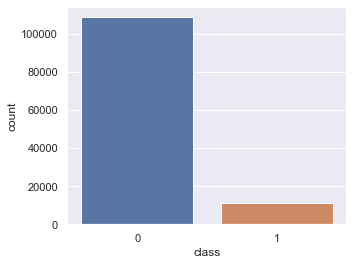

In [11]:
for ind,val in enumerate(df_transactions["class"].value_counts()):
    print("# of records for Class "+str(ind)+":"+str(val))
    
print("Percentage of records with label 1 - Fraud: "+
      str(np.round((df_transactions["class"].value_counts()[1]/df_transactions["class"].value_counts().values.sum())*100,1))+"%")

sns.set(rc = {'figure.figsize':(5,4)})
ax = sns.countplot(x ='class', data = df_transactions)


#### 2.2 Categorical Features:
<b>1. Source</b>
- Three source types SEO, Ads, Direct
- "Direct" source has slight high percentage of fraud records

In [12]:
df_transactions.groupby('source').agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))

,count,fraud_ratio
source,,
Ads,47461,0.091696
Direct,24242,0.105643
SEO,48297,0.090109


<b> 2. Browser </b>
- Five main browsers
- Chrome and IE are mainly used by users
- No clear indication on fraud if we consider "browser" column alone

In [13]:
df_transactions.groupby('browser').agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))

,count,fraud_ratio
browser,,
Chrome,48652,0.099441
FireFox,19615,0.094112
IE,29138,0.086107
Opera,2975,0.091429
Safari,19620,0.091743


<b>3. Sex </b>
- Male gender has slight high fraud ratio compared to female gender

In [14]:
df_transactions.groupby('sex').agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))

,count,fraud_ratio
sex,,
F,49874,0.091671
M,70126,0.095442


<b>4. country </b>
- Top 10 countries with highest fraud ratio

In [15]:
df_country = df_transactions.groupby('country').agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))
df_country.query('count > 10').nlargest(15, 'fraud_ratio')

,count,fraud_ratio
country,,
Namibia,20,0.400000
Luxembourg,56,0.392857
Sri Lanka,22,0.363636
Peru,94,0.287234
Ecuador,87,0.264368
Tunisia,89,0.258427
Bolivia,46,0.239130
Ireland,197,0.238579
Kuwait,72,0.236111


- Top 10 countries with most transactions

In [16]:
df_country = df_transactions.groupby('country').agg(count=('class', 'size')).sort_values("count", ascending =False)[:10]
df_country

,count
country,
United States,46184
UNK,17418
China,9532
Japan,5735
United Kingdom,3580
Korea Republic of,3341
Germany,2890
France,2489
Brazil,2353


#### 2.2.1Categorical features class distributions

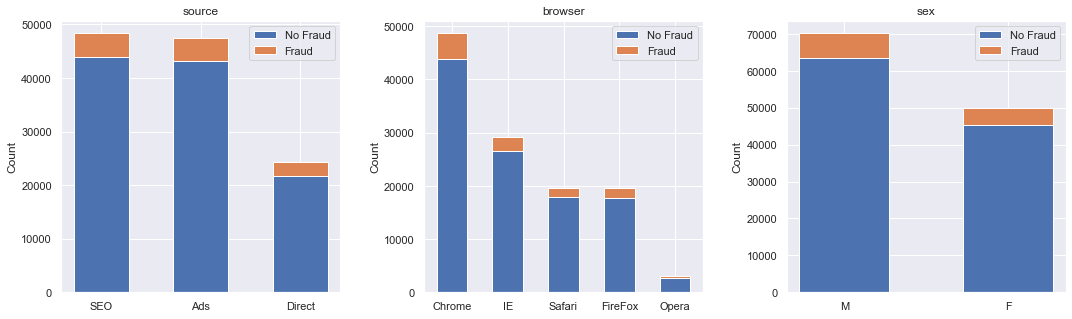

In [17]:
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
cat_features = ["source","browser","sex"]
for i in range(len(cat_features)):
    ax = fig.add_subplot(1, len(cat_features),i+1)
    labels = df_transactions[cat_features[i]].value_counts().index
    class_0 = df_transactions[df_transactions["class"]==0][cat_features[i]].value_counts().values
    class_1 = df_transactions[df_transactions["class"]==1][cat_features[i]].value_counts().values   
    ax.bar(labels, class_0, width = 0.55, label='No Fraud')
    ax.bar(labels, class_1, width = 0.55, bottom=class_0,
           label='Fraud')
    ax.set_ylabel('Count')
    ax.set_title(cat_features[i])
    ax.legend()



#### 2.3 Numerical features
- Age:
    - Age is more normally distributed
    - Majority of the users are in between late 20's to late 30's 
- Purchase_value:
    - The value of the majority of the items that were purchased is less than 50 
    - On average the cost of products sold on the ecommerce site is around 37 dollars
    - The cost incurred due to a flase positive is 8 dollars.
    - The model we will be developing should be slightly high recall model as the average cost of product is more than the cost incurred due to a flase positive

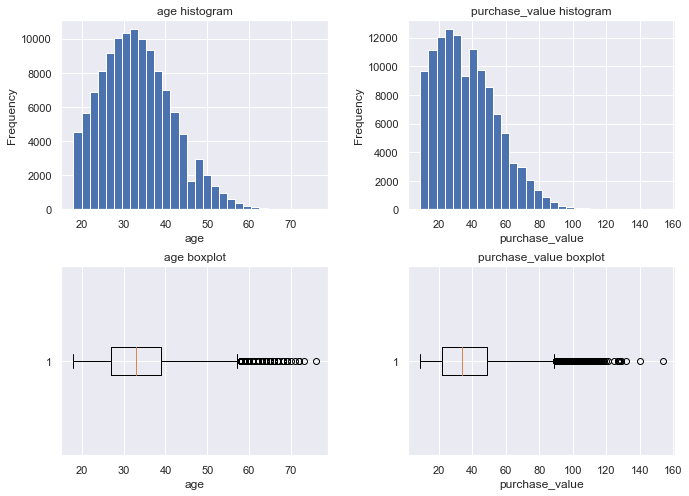

In [18]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
numerical_features = ["age","purchase_value"]
for i in range(len(numerical_features)):
    ax = fig.add_subplot(2, len(numerical_features),i+1)
    ax.hist(x=df_transactions[numerical_features[i]], bins=30)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(numerical_features[i])
    ax.set_title(numerical_features[i]+' histogram')
    ax = fig.add_subplot(2, len(numerical_features),i+1+len(numerical_features))
    ax.boxplot(x=df_transactions[numerical_features[i]],vert=False)
    ax.set_xlabel(numerical_features[i])
    ax.set_ylabel('')
    ax.set_title(numerical_features[i]+' boxplot')

#### Additional Feature 1.
Time difference between the signup and purchase time

In [19]:
df_transactions["time_difference"] = (df_transactions["signup_time"]-df_transactions["purchase_time"]).dt.seconds
df_transactions.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_difference
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,51540
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,27360
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,45060
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,11220
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,24300


- For fraudualent transactions, it is clear that the transactions are made very quickly (<=1 sec in many cases)
- with this new feature we see a clear pattern to identify fradualent ransactions

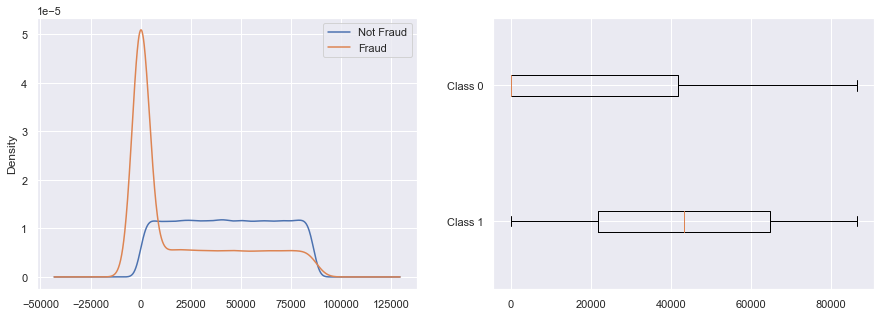

In [20]:
## justification
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df_transactions.groupby("class").time_difference.plot(kind = 'kde', legend = True, ax=ax[0]);
ax[0].legend(['Not Fraud', 'Fraud'])

ax[1].boxplot([df_transactions[df_transactions["class"]==0]["time_difference"],
            df_transactions[df_transactions["class"]==1]["time_difference"]],
           vert=False);
ax[1].set_yticklabels(['Class 1', 'Class 0']);




#### Additional Feature 2.
- How many times same device is being used by different users
- High number of users using the same device is directly proportional to fraud ratio
- Good indicator to consider in model development

In [21]:
df_transactions["devices_used_count"] = df_transactions.groupby("device_id")["user_id"].transform("count")
df_transactions.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_difference,devices_used_count
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,51540,2
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,27360,1
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,45060,1
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,11220,1
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,24300,1


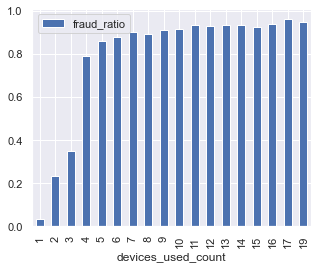

In [22]:
df_transactions.groupby('devices_used_count')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("devices_used_count").plot("devices_used_count","fraud_ratio",kind="bar");


#### Additonal Feature 3.
- Number of different ip address used by same user-id
- Same user_id using multiple ip address good indicator of fraud as it is rare and when it happens the fraud ratio is high

In [23]:
# Check user number for unique ip_address
df_transactions["multiple_ip_addrs"] = df_transactions.groupby("ip_address")["user_id"].transform("count")
df_transactions.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_difference,devices_used_count,multiple_ip_addrs
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,51540,2,1
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,27360,1,1
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,45060,1,1
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,11220,1,1
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,24300,1,1


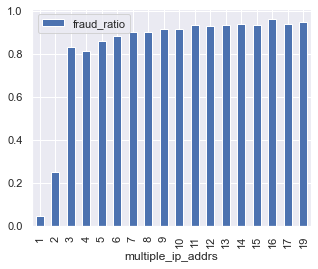

In [24]:
df_transactions.groupby('multiple_ip_addrs')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("multiple_ip_addrs").plot("multiple_ip_addrs","fraud_ratio",kind="bar");

#### Additional features 4 & 5: "signup_time" based additional features :
- Signup time: day
    - Less likely to get a fraudulent transaction on Wednesday and Tuesday (middle of a week) compared to other weeks
- Signup time: week number
    - High chances of fraud to occur during the starting weeks of an year

In [25]:
# Signup time features
df_transactions['signup_time_day'] = df_transactions['signup_time'].apply(lambda x: x.day_name())
df_transactions['signup_time_week'] = df_transactions['signup_time'].apply(lambda x: x.week)

df_transactions.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_difference,devices_used_count,multiple_ip_addrs,signup_time_day,signup_time_week
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,51540,2,1,Wednesday,29
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,27360,1,1,Saturday,4
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,45060,1,1,Wednesday,11
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,11220,1,1,Wednesday,2
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,24300,1,1,Sunday,6


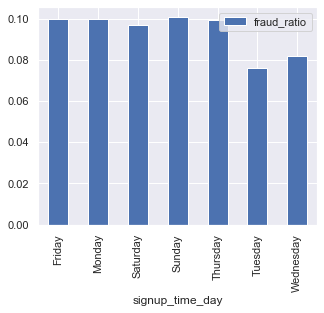

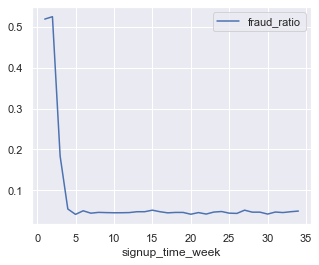

In [26]:
df_transactions.groupby('signup_time_day')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("signup_time_day").plot("signup_time_day","fraud_ratio",kind="bar");

df_transactions.groupby('signup_time_week')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("signup_time_week").plot("signup_time_week","fraud_ratio",kind="line");

#### Additional features 6 & 7: "purchase_time" based additional features :
- Purchase time: day
- Purchase time: week number
- Same patterns of signup date features occur in purchase time as well


In [27]:
# Purchase time features
df_transactions['purchase_time_day'] = df_transactions['purchase_time'].apply(lambda x: x.day_name())
df_transactions['purchase_time_week'] = df_transactions['purchase_time'].apply(lambda x: x.week)

df_transactions.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_difference,devices_used_count,multiple_ip_addrs,signup_time_day,signup_time_week,purchase_time_day,purchase_time_week
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,51540,2,1,Wednesday,29,Thursday,37
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,27360,1,1,Saturday,4,Monday,16
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,45060,1,1,Wednesday,11,Sunday,14
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,11220,1,1,Wednesday,2,Friday,2
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,24300,1,1,Sunday,6,Thursday,15


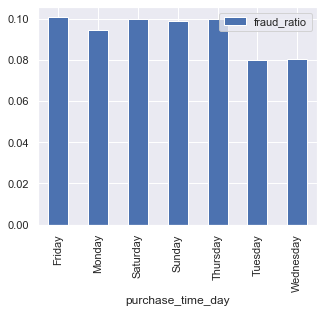

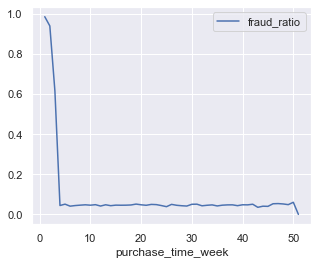

In [28]:
df_transactions.groupby('purchase_time_day')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("purchase_time_day").plot("purchase_time_day","fraud_ratio",kind="bar");

df_transactions.groupby('purchase_time_week')\
.agg(count=('class', 'size'), fraud_ratio=('class', 'mean'))\
.reset_index()\
.sort_values("purchase_time_week").plot("purchase_time_week","fraud_ratio",kind="line");

#### Correlation plot
 - "devices_used_count" and "multiple_ip_addrs" features are strongly and positively correlated to target label
 - "devices_used_count" and "multiple_ip_addrs" are collinear and redundant features
 - "time_difference", "signup_time_week" and "purchase_time_week" are negatively correlated to target label
 - "signup_time_week" and "purchase_time_week" are collinear and redundant features

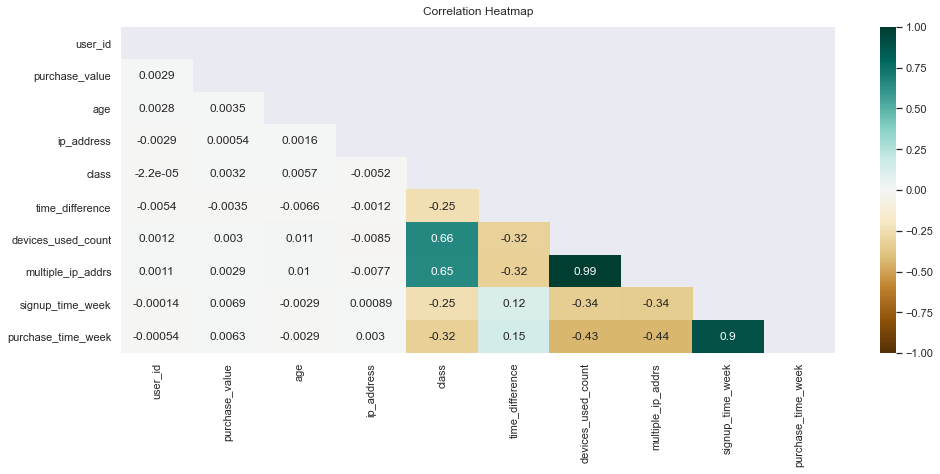

In [29]:
corr_matrix = df_transactions.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);